![LogoUC3M](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/Acr%C3%B3nimo_y_nombre_de_la_UC3M.svg/320px-Acr%C3%B3nimo_y_nombre_de_la_UC3M.svg.png)

*GRUPO 21 | Alonso Rios Guerra - 100495821 | Guillermo Sancho González - 100495991 | GitHub: https://github.com/100495991/AA_practica2*



# *__Aprendizaje automático P2: Clustering de semillas__*

## *__1. Introducción__*

En esta práctica tenemos como objetivo desarrollar diferentes métodos de clustering sobre un conjunto de datos de semillas para comprobar si aparecen agrupaciones significativas en estos atributos, y qué técnica de clustering es la más efectiva en este caso.

Primero de todo empezaremos leyendo los datos proporcionados y los almacenamos en un DataFrame. Dividimos éstos datos en X (atributos de las semillas) e y (clase de las semillas). Para asegurar la reproducibilidad de los resultados hemos definido la seed como 100495991, NIA universitario.

In [103]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, scale
import numpy as np
import pandas as pd

data_path = 'semillas.csv'

seed = 1004959991

data = pd.read_csv(data_path, sep = ',')

X = data.drop(columns=['clase'])
y = data['clase']
target_names = sorted(y.unique().tolist())

## *__2 . Elección de Scaler y Principal Component Analysis__*

Tras realizar una pequeña representación de como afecta el número de componentes principales a la varianza, observamos que para el número de componentes especificadas en el enunciado (2) el mejor scaler es MinMaxScaler() con un 91,81% de varianza. Más adelante, contrastaremos este análisis precoz sobre cuál es el mejor scaler.

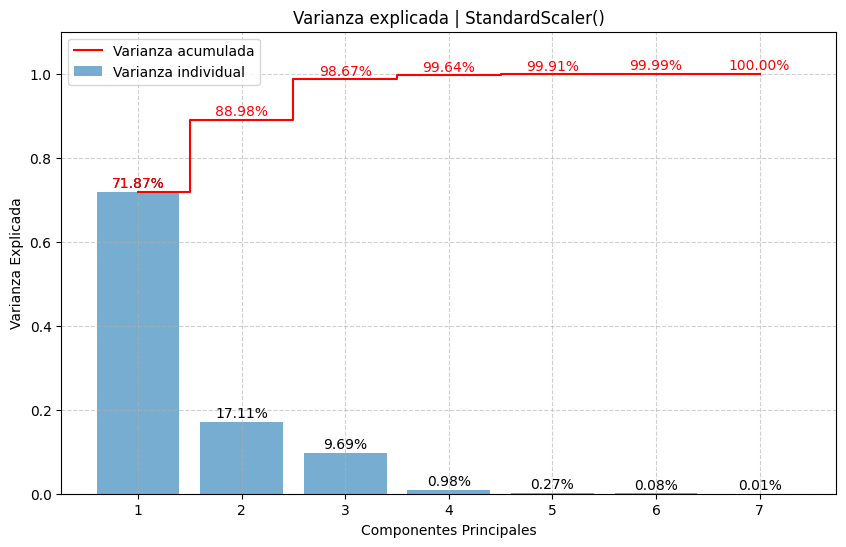

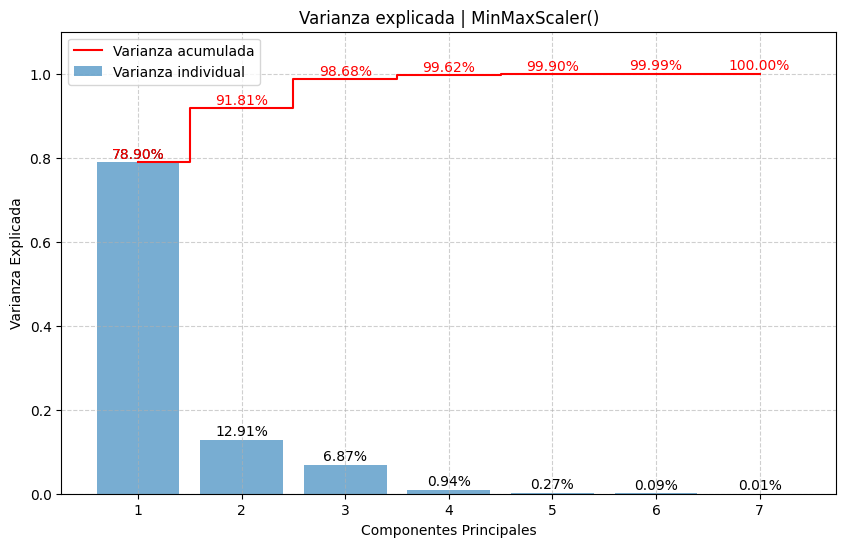

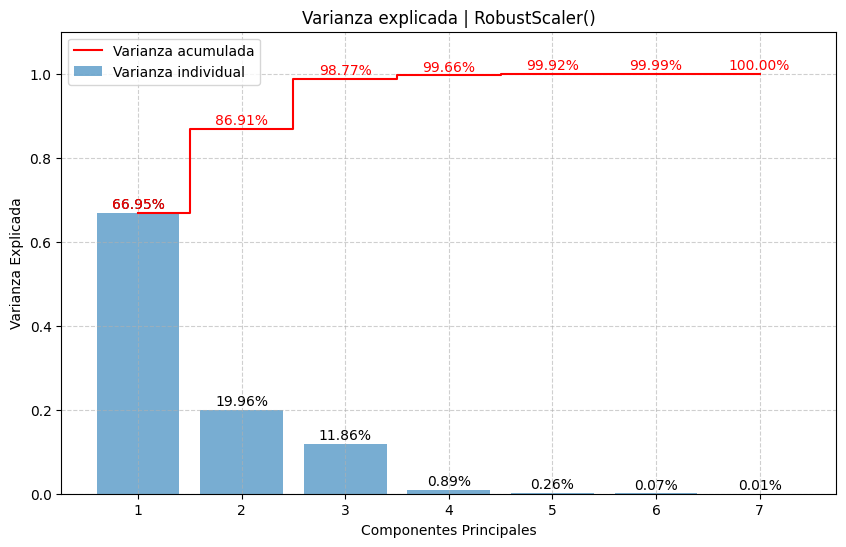

In [104]:
for scaler in (StandardScaler(), MinMaxScaler(), RobustScaler()):
    pipeline = Pipeline([
    ('scaler', scaler),  # Siempre escalar antes de PCA
    ('pca', PCA(random_state=seed))
    ])

    # Ajustar y transformar
    X_reduced = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']

    # Varianza explicada y acumulada
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # 1. Plot de Varianza Explicada y Acumulada
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza individual')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Varianza acumulada', color='red')

    # Añadir valores exactos
    for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
        plt.text(i + 1, ev + 0.01, f"{ev:.2%}", ha='center')
        plt.text(i + 1, cv + 0.01, f"{cv:.2%}", ha='center', color='red')

    plt.xlabel('Componentes Principales')
    plt.ylabel('Varianza Explicada')
    plt.title('Varianza explicada | ' + str(scaler) )
    plt.legend(loc='best')
    plt.ylim(0, 1.1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Ahora aplicaremos PCA con 2 componentes, lo que hace una transformación no supervisada a 2 dimensiones, de tal manera que los datos puedan ser visualizados en 2D.

Para elegir el mejor Scaler se hace PCA con cada uno de ellos: StandardScaler, MinMaxScaler y RobustScaler para comprobar cual tiene mayor varianza explicada.

La varianza explicada representa cuánta varianza de los datos originales explican las dos componentes obtenidas tras aplicar PCA.
Cuanta mayor varianza explicada haya, menos información se perderá.

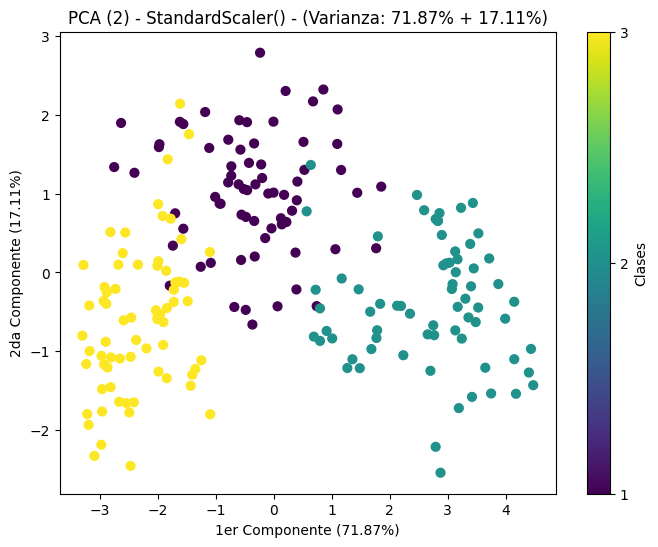

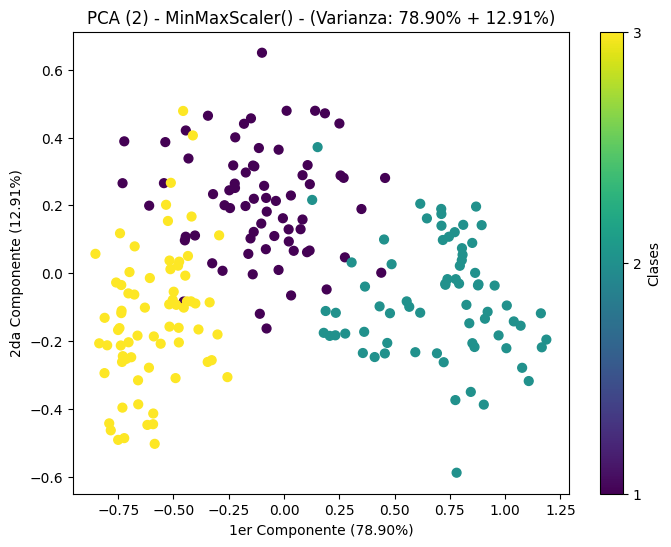

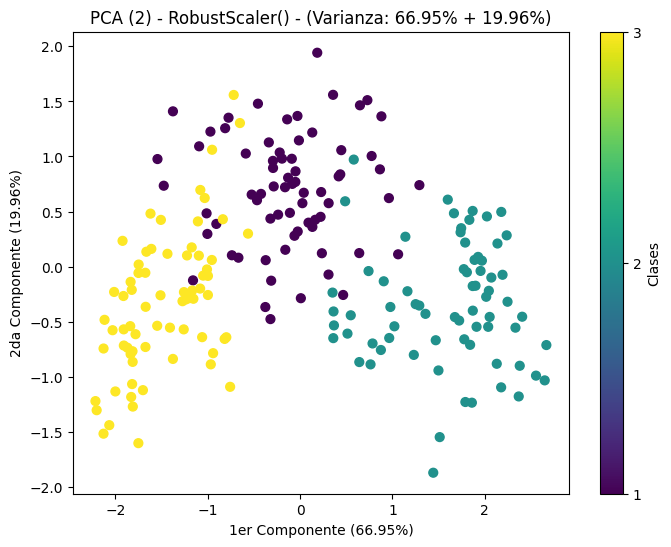

In [105]:
bestScaler = None
bestVariance = 0.0
for scaler in (StandardScaler(), MinMaxScaler(), RobustScaler()):
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2, random_state=seed))
    ])

    X_reduced = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=40, cmap='viridis')
    plt.title('PCA (2) - {} - (Varianza: {:.2%} + {:.2%})'.format(scaler,explained_variance[0], explained_variance[1]))
    plt.xlabel('1er Componente ({:.2%})'.format(explained_variance[0]))
    plt.ylabel('2da Componente ({:.2%})'.format(explained_variance[1]))
    cbar = plt.colorbar(scatter, ticks=[1, 2, 3])
    cbar.set_label('Clases')
    plt.show()

    if sum(explained_variance) > bestVariance:
        bestVariance = sum(explained_variance)
        bestScaler = scaler

Observando estos gráficos se puede ver como el mejor Scaler para este modelo es el MinMaxScaler(), debido que obtienen la mayor varianza explicada total entre la suma de las dos componentes, 91.81%. Esto implica, en otras palabras, que es el que menos información pierde. Este resultado contrasta el análisis realizado anteriormente.

## *__3 . Selección mejor técnica de clustering__*

Una vez seleccionado el mejor scaler, en nuestro caso MinMaxScaler(), y haber transformado los datos a 2D, se aplicarán las técnicas de clustering explicadas en clase: K-Means, Hierarchical Clustering/Dendrogramas, DBSCAN.


### *__3.1 . K-means__*

Como primer método usaremos K-means para determinar el número óptimo de clusters. Aplicaremos K-means usando el método del códo y Silhouette.

Empezaremos con el método del códo.

In [106]:
from sklearn.cluster import KMeans
pipeline = Pipeline([
    ('scaler', bestScaler),
    ('pca', PCA(n_components=2))
])

X_pca = pipeline.fit_transform(X)
pca = pipeline.named_steps['pca']

Text(0, 0.5, 'Intra-cluster (inertia)')

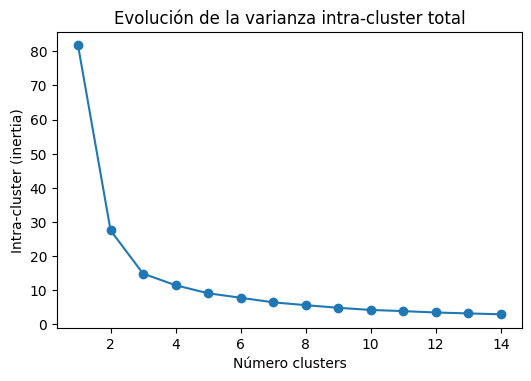

In [107]:
# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = seed
    )
    modelo_kmeans.fit(X_pca)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)')

Para elegir cual es el número de clusters óptimo hay que elegir el del punto "codo", es decir, cuando se empienza a aplanar la curva. En este caso es 3 clusters. Este resultado contraste con la "solución" que se encontraba inicialmente en el dataset.

Con el fin de contrastar y de poder determinar el número de clusters de una manera más precisa, vamos a aplicar el Silhouette.

Text(0, 0.5, 'Media índices silhouette')

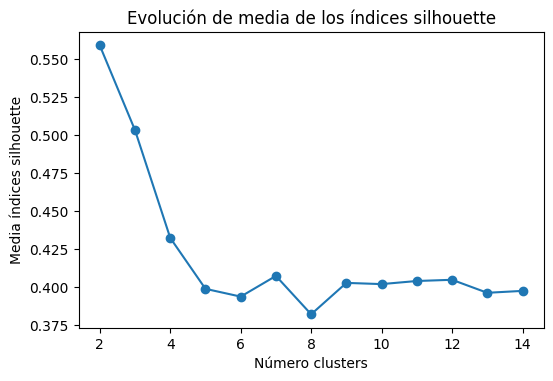

In [108]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
from sklearn.metrics import silhouette_score
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = seed
    )
    cluster_labels = modelo_kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')

Como podemos observar en el gráfico, el mejor valor parece ser 2 clusters pero también observamos que 3 clusters obtiene un resultado similar al de 2 clusters. Es por ello que combinado al resultado obtenido en el método del códo y debido a la poca diferencia obtenida en Silhouette entre 2 y 3, seleccionamos como número óptimo de clusters n_clusters = 3.

A continuación, vamos a mostrar unos gráficos que nos permiten apreciar la separación en 3 clusters aplicada por Kmeans. Además se muestran los centroides de cada cluster.

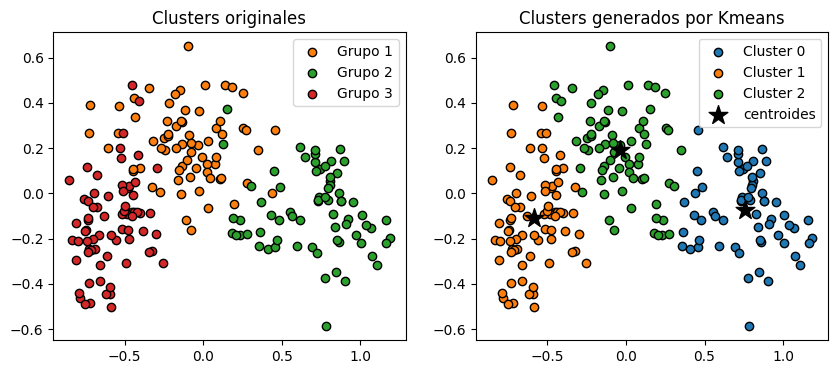

In [109]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

modelo_kmeans = KMeans(n_clusters=3, n_init=20, random_state=seed)
modelo_kmeans.fit(X=X_pca)
y_predict = modelo_kmeans.predict(X=X_pca)

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_pca[y == i, 0],
        y = X_pca[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend()

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_pca[y_predict == i, 0],
        y = X_pca[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend()


También se puede observar en la siguiente matriz de confusión la comparación con el resultado proporcionado en el dataset.

In [110]:
pd.crosstab(y, y_predict, dropna=False, rownames=['grupo_real'], colnames=['cluster'])

cluster,0,1,2
grupo_real,,,
1,2,10,58
2,61,0,9
3,0,67,3


Precisión obtenida: 88,57%

### *__3.2 . Hierarchical Clustering/Dendrogramas__*

Ahora aplicaremos clustering jerárquico y dendogramas. Primero definimos una función que nos será útil a la hora de representar los dendogramas para cada tipo de función de linkage.

In [111]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

A continuación, haremos AgglomerativeClustering() variando el tipo de función linkage (complete, average, ward y single). Esto nos dará un total de 4 modelos.

In [112]:
modelo_hclust_complete = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=X_pca)

modelo_hclust_average = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=X_pca)

modelo_hclust_ward = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=X_pca)

modelo_hclust_single = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'single',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_single.fit(X=X_pca)

AgglomerativeClustering(distance_threshold=0, linkage='single', n_clusters=None)

Ahora vamos a representar los dendogramas de cada módelo. Con estos dendogramas, seremos capaces de seleccionar el mejor modelo y función linkage.

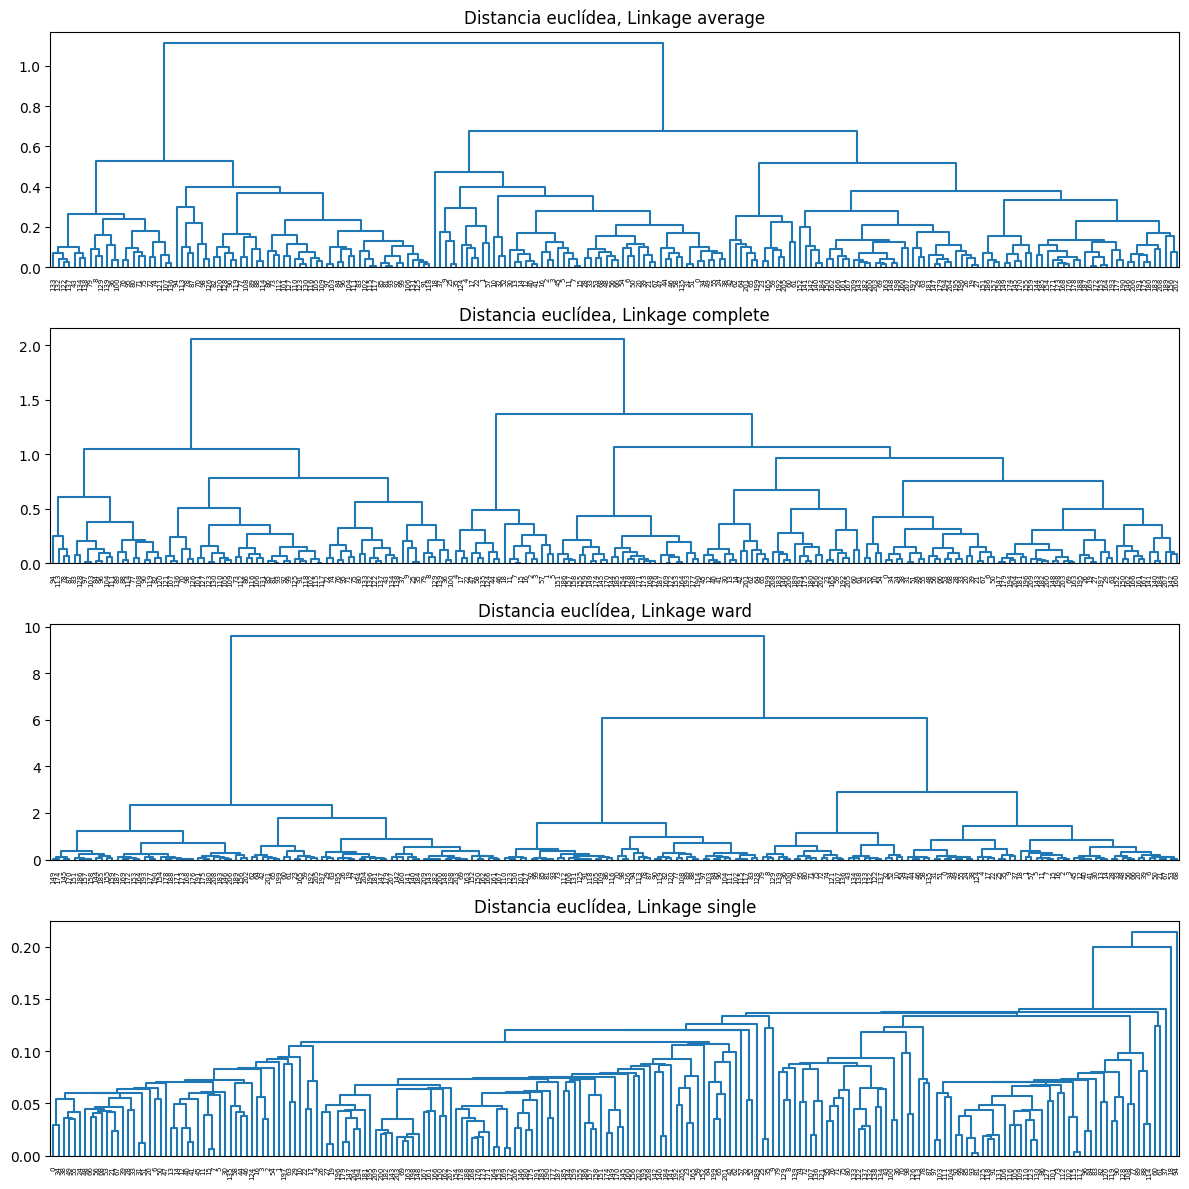

In [113]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12))
X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=data.index)

plot_dendrogram(modelo_hclust_average, labels=X_pca.index, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_complete, labels=X_pca.index, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, labels=X_pca.index, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plot_dendrogram(modelo_hclust_single, labels=X_pca.index, color_threshold=0, ax=axs[3])
axs[3].set_title("Distancia euclídea, Linkage single")
plt.tight_layout()

Visualmente ya se aprecia que la función linkage más prometedora es WARD, esto se debe a que observa un gran salto en las distancias. Es por ello que nos basaremos en esta función para determinar el número de óptimo de clusters. Una vez escogida la función linkage, aplicaremos el método de silhouette para obtener dicho número de clusters.

Text(0, 0.5, 'Media índices silhouette')

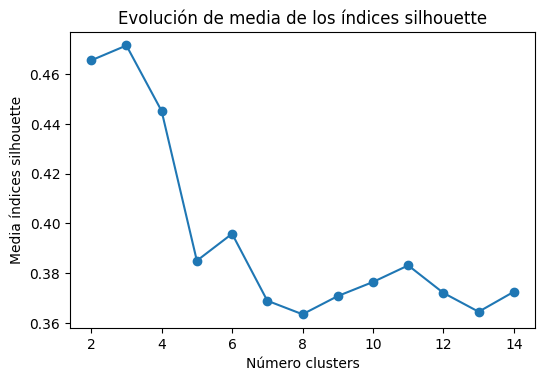

In [114]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        metric   = 'euclidean',
        linkage    = 'ward',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')

Al aplicar silhouette obtenemos que el mejor resultado se obtiene con un número de clusters igual a 3. Esto es una excelente ya que coincide con la "solución" proporcionada en el dataset.

In [115]:
# Modelo final
# ==============================================================================
modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    n_clusters = 3
)
modelo_hclust_ward.fit(X=X_pca)

AgglomerativeClustering(n_clusters=3)

Ahora mostraremos varios gráficos sobre las alturas de fusiones en el dendograma. Esto también nos ayudará a elegir la altura de corte, nos interesa elegir la mayor diferencia de alturas posible. Con esta altura de corte, posteriormente podremos determinar el número de clusters cortando el dendograma y observando el número de ramas que corta.

Altura de fusión óptima: 6.09


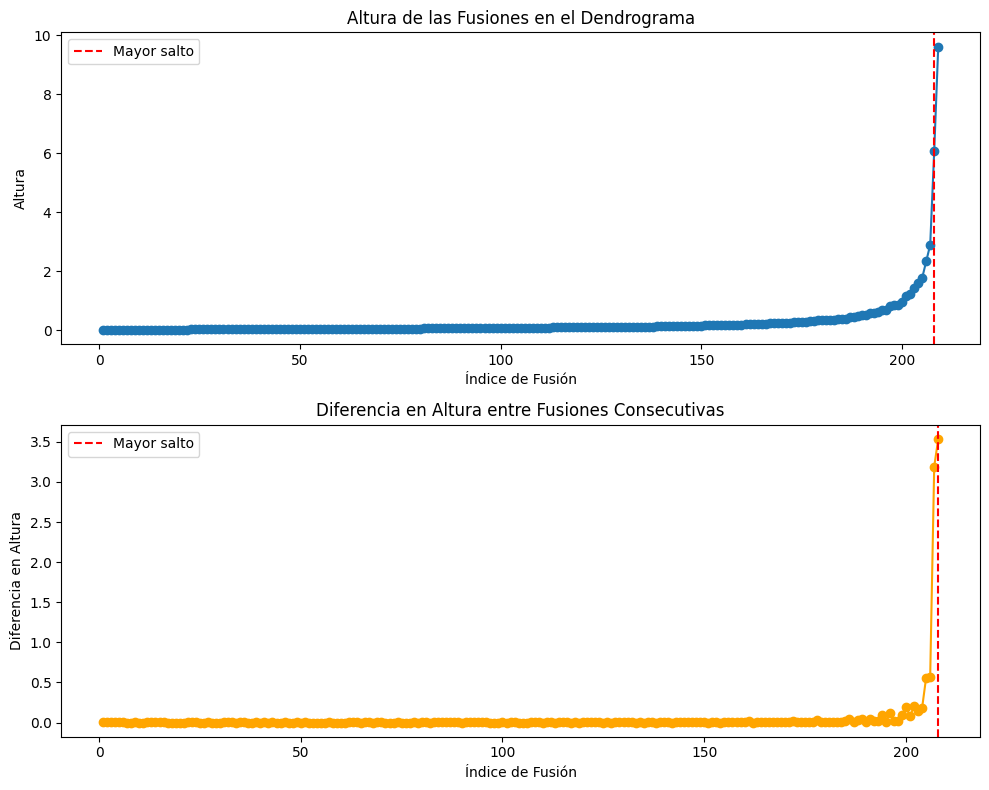

In [116]:
import scipy.cluster.hierarchy as sch

# Calculamos la matriz de enlace con linkage 'ward'
Z = sch.linkage(X_pca , method='ward')

# Extraemos las alturas de fusión
heights = Z[:, 2]  # La tercera columna contiene las alturas de fusión

# Calculamos las diferencias entre alturas consecutivas
diffs = np.diff(heights)

# Índice donde ocurre el mayor salto en altura
idx_max_jump = np.argmax(diffs)

# Número óptimo de clusters basado en el mayor salto
n_clusters_optimo = len(heights) - idx_max_jump

# Altura de fusión en el mayor salto
altura_optima = heights[idx_max_jump]

print(f"Altura de fusión óptima: {altura_optima:.2f}")
    
# Ahora ploteamos la información

# Graficamos la altura de fusión y su incremento
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico de las alturas de fusión
ax[0].plot(range(1, len(heights) + 1), heights, marker='o', linestyle='-')
ax[0].set_title("Altura de las Fusiones en el Dendrograma")
ax[0].set_xlabel("Índice de Fusión")
ax[0].set_ylabel("Altura")
ax[0].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
ax[0].legend()

# Gráfico del incremento en altura
ax[1].plot(range(1, len(diffs) + 1), diffs, marker='o', linestyle='-', color='orange')
ax[1].set_title("Diferencia en Altura entre Fusiones Consecutivas")
ax[1].set_xlabel("Índice de Fusión")
ax[1].set_ylabel("Diferencia en Altura")
ax[1].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
ax[1].legend()

plt.tight_layout()
plt.show()

A pesar de haber obtenido como número óptimo de clusters 2, sabemos que estos datos no son del todo precisos y estan sujetos a cierto error al otorgar los mismos pesos a todos los atributos. Por ello, es conveniente contrastarlo con más información.

Es por ello que calculamos la altura a la que se produce el mayor salto. Esta altura será nuestra altura de corte.

Altura de fusión óptima: 6.09


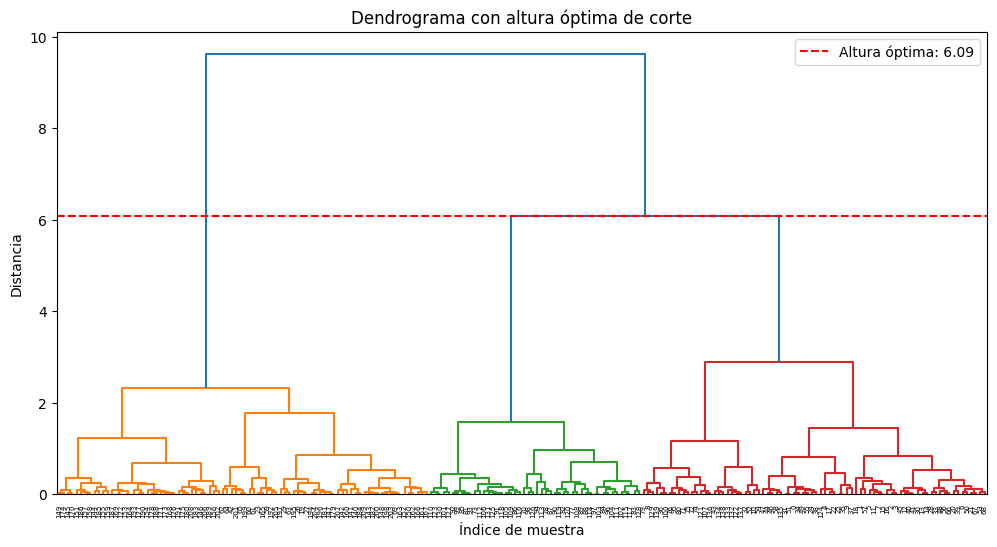

In [117]:
print(f"Altura de fusión óptima: {altura_optima:.2f}")

# Graficamos el dendrograma
plt.figure(figsize=(12, 6))
sch.dendrogram(Z, color_threshold=altura_optima)  # Coloriza los clusters a esa altura
plt.axhline(y=altura_optima, color='r', linestyle='dashed', label=f'Altura óptima: {altura_optima:.2f}')
plt.title("Dendrograma con altura óptima de corte")
plt.xlabel("Índice de muestra")
plt.ylabel("Distancia")
plt.legend()
plt.show()

Al aplicar el corte en nuestro dendograma, observamos que se cortan 3 ramas lo que implica que el número óptimo de clusters es 3.

Para visualizar los datos obtenidos realizar un plot, y crear la matriz de confusión para comprobar la precisión.

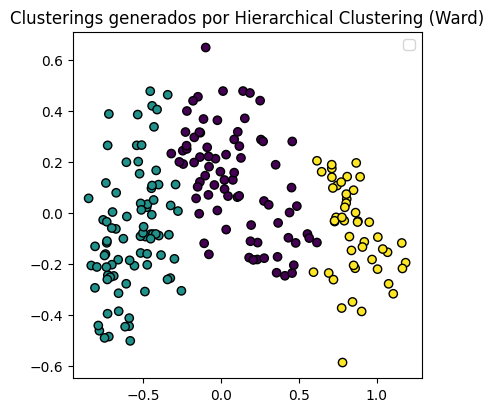

cluster,0,1,2
grupo_real,,,
1,56,14,0
2,22,0,48
3,0,70,0


In [118]:
# Aplicamos clustering jerárquico con el número óptimo de clusters
y_predict2 = modelo_hclust_ward.fit_predict(X_pca)

# Visualizamos los clusters en el espacio PCA de la misma forma que DBSCAN
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

# Visualización de los clusters con colores
scatter = ax.scatter(
    x = X_pca['PC1'],
    y = X_pca['PC2'],
    c = y_predict2,
    marker    = 'o',
    edgecolor = 'black'
)

# Añadimos la leyenda
ax.legend()
ax.set_title('Clusterings generados por Hierarchical Clustering (Ward)')

# Visualización de la gráfica
plt.show()

# Para mostrar una tabla de los clusters generados (similar al crosstab de DBSCAN)
pd.crosstab(y, y_predict2, dropna=False, rownames=['grupo_real'], colnames=['cluster'])



### *__3.3 . DBSCAN__*

La útlima técnica de clustering es DBSCAN, esta técnica consiste en definir agrupaciones de puntos de alta densidad separadas por regiones de baja densidad. Existen dos parámetros que intervienen directamente sobre esta técnica y son el eps y el min_samples. El eps es la distancia máxima entre dos muestras para que puedan ser consideradas vecinas mientras que el min_samples es el número de muestras necesario para que un punto pueda considerarse el núcleo.

A continuación, vamos a mostrar unos gráficos que muestran el resultado de aplicar DBSCAN sin ajustar epsilon ni min_samples.

Text(0.5, 1.0, 'Clusterings generados por DBSCAN con eps=0.2 y min_samples=5')

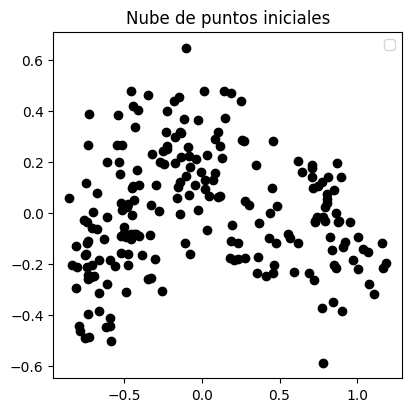

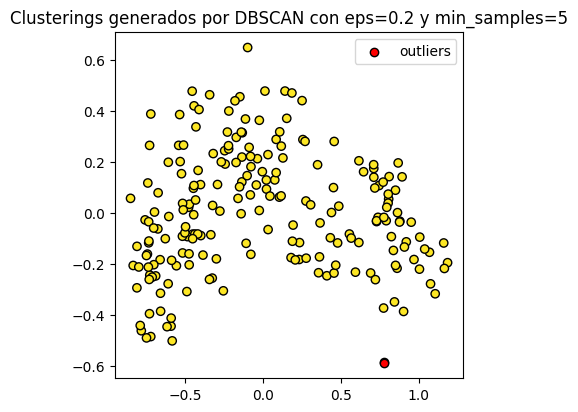

In [119]:
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_pca.iloc[:, 0],
    y = X_pca.iloc[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = 0.2,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_pca)

# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_pca.iloc[:, 0],
    y = X_pca.iloc[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_pca.iloc[labels == -1, 0],
    y = X_pca.iloc[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN con eps=0.2 y min_samples=5')

Como era de esperar, con valores sin ajustar como eps=0.2 y min_samples=5, obtenemos resultados muy alejados de la realidad. Por ejemplo, en el número de clusters generados obtenemos 1 lo cúal no aporta ningún valor a la hora de agrupar features. También podemos contrastar este resultado con el proporcionado en el dataset y vemos que esta alejado, 1 cluster respecto a 3 clusters.

Ahora nos dispondremos a ajustar el parámetro eps de DBSCAN, para ello haremos uso de un gráfico en el que se observa la k-distance con sus vecinos. En el eje y se representa la eps y al igual que en el método del codo cogeremos el punto donde se aplana el gráfico. Al definir ese punto, la eps será la coordenada y del mismo.

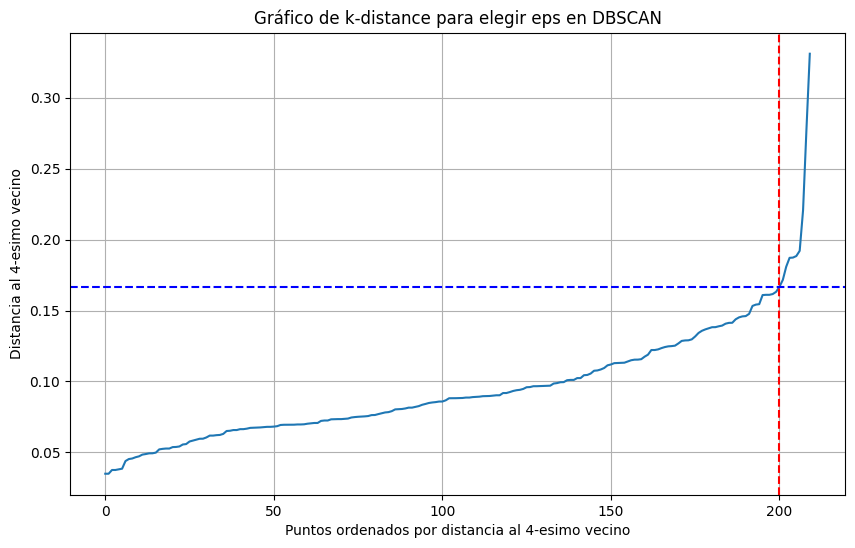

x_point=200 y_value=0.16673162014672105


In [120]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

min_samples = 5

# Compute the nearest neighbors
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_pca)
distances, indices = nn.kneighbors(X_pca)

# Sort the distances
sorted_distances = np.sort(distances[:, min_samples-1], axis=0)

x_point = 200
y_value = sorted_distances[x_point]  # Obtener el valor de la distancia para ese punto

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.xlabel('Puntos ordenados por distancia al {}-esimo vecino'.format(min_samples-1))
plt.ylabel('Distancia al {}-esimo vecino'.format(min_samples-1))
plt.title('Gráfico de k-distance para elegir eps en DBSCAN')

plt.axvline(x=x_point, color='r', linestyle='--')

# Dibujar la línea horizontal correspondiente en el eje Y
plt.axhline(y=y_value, color='b', linestyle='--')

plt.grid(True)
plt.show()

print(f'{x_point=} y_value={y_value}')

Como se puede ver, hemos obtenido un eps de 0.16 aproximadamente. Por ello ahora aplicaremos DBSCAN usando esa eps. Para ajustar los min_samples optamos por ejecutar varias veces DBSCAN variando min_samples hasta que obtuvimos un resultado que nos parecía acorde a los datos y similar a los otros métodos de clustering.

Número de clusters encontrados: 3
Número de outliers encontrados: 72


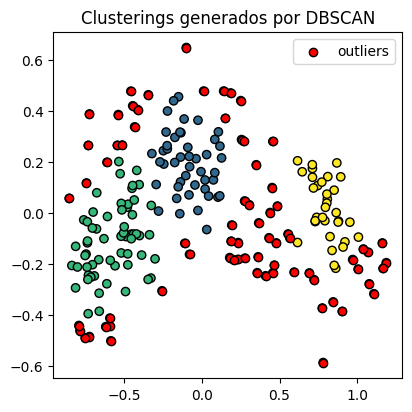

In [121]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = y_value,
    min_samples  = 18,
    metric       = 'euclidean',
)

y_predict3 = modelo_dbscan.fit_predict(X=X_pca)

# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_pca.iloc[:, 0],
    y = X_pca.iloc[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_pca.iloc[labels == -1, 0],
    y = X_pca.iloc[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN')

# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')





## *__4 . Análisis__*

Analizando visualmente y evaluando los resultados obtenidos tras aplicar los 3 métodos de clustering, se intuye que el mejor método y el que mejor se ajusta a las clases reales es el método K-Means.

El método DBSCAN  es fácil descartarlo porque la solución obtenida nos da un número de outliers muy elevado (72, más de un 34% de los datos originales). Por otro lado, los plots para visualizar K-means y el clustering jerárquico son bastante similares pero visualmente parece que agrupa mejor K-Means.


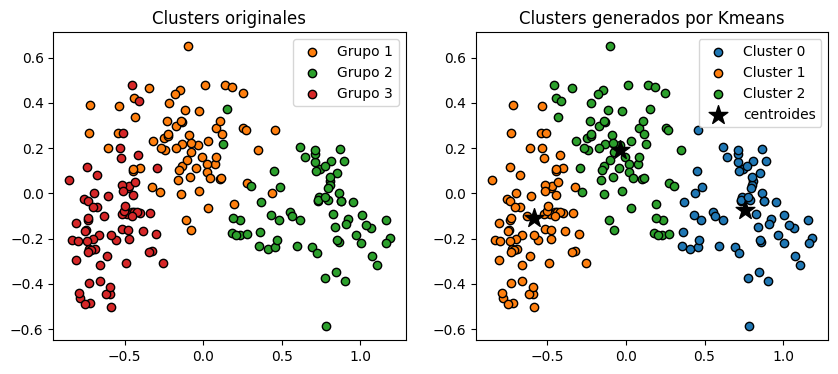
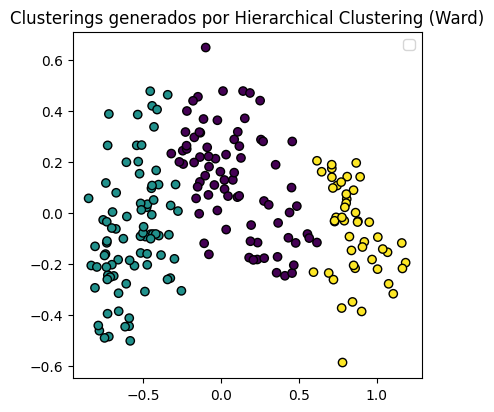
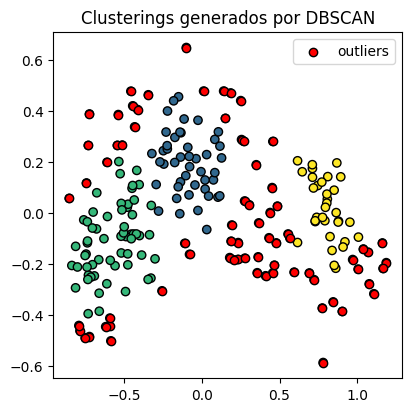


Se puede decir que sí hay relación entre los clusters obtenidos y las clases de las semillas originales. Esto se puede apreciar fácilmente viendo la matriz de confusión que se hizo con K-Means.

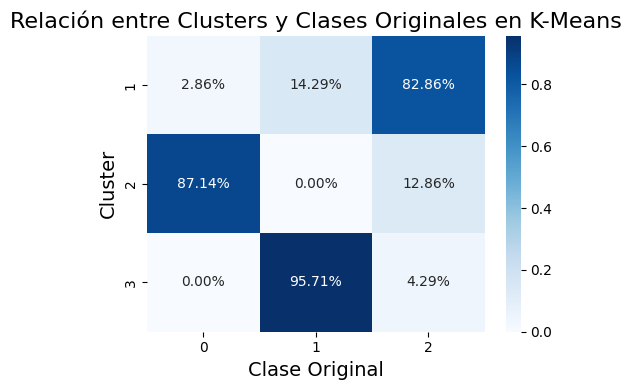

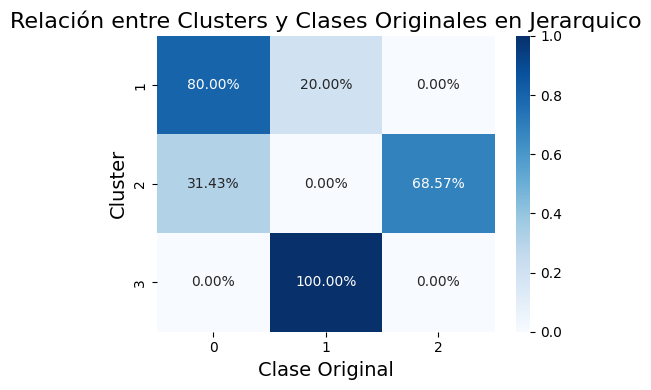

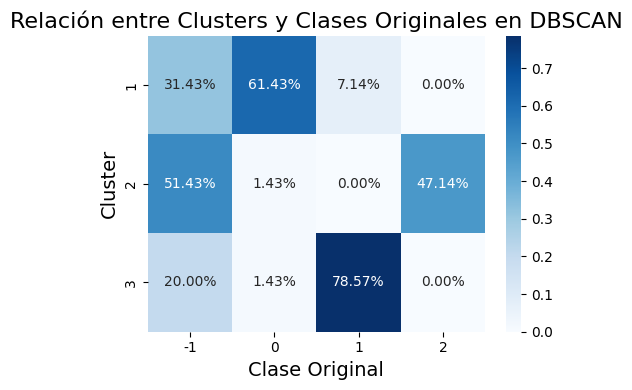

In [122]:
import seaborn as sns
contingencia = pd.crosstab(y, y_predict, dropna=False, rownames=['grupo_real'], colnames=['cluster'], normalize='index')
plt.figure(figsize=(5, 4))
sns.heatmap(contingencia, annot=True, cmap='Blues', fmt='.2%')
plt.title('Relación entre Clusters y Clases Originales en K-Means', fontsize=16)
plt.xlabel('Clase Original', fontsize=14)
plt.ylabel('Cluster', fontsize=14)
plt.tight_layout()
plt.show()

contingencia = pd.crosstab(y, y_predict2, dropna=False, rownames=['grupo_real'], colnames=['cluster'], normalize='index')
plt.figure(figsize=(5, 4))
sns.heatmap(contingencia, annot=True, cmap='Blues', fmt='.2%')
plt.title('Relación entre Clusters y Clases Originales en Jerarquico', fontsize=16)
plt.xlabel('Clase Original', fontsize=14)
plt.ylabel('Cluster', fontsize=14)
plt.tight_layout()
plt.show()

contingencia = pd.crosstab(y, y_predict3, dropna=False, rownames=['grupo_real'], colnames=['cluster'], normalize='index')
plt.figure(figsize=(5, 4))
sns.heatmap(contingencia, annot=True, cmap='Blues', fmt='.2%')
plt.title('Relación entre Clusters y Clases Originales en DBSCAN', fontsize=16)
plt.xlabel('Clase Original', fontsize=14)
plt.ylabel('Cluster', fontsize=14)
plt.tight_layout()
plt.show()

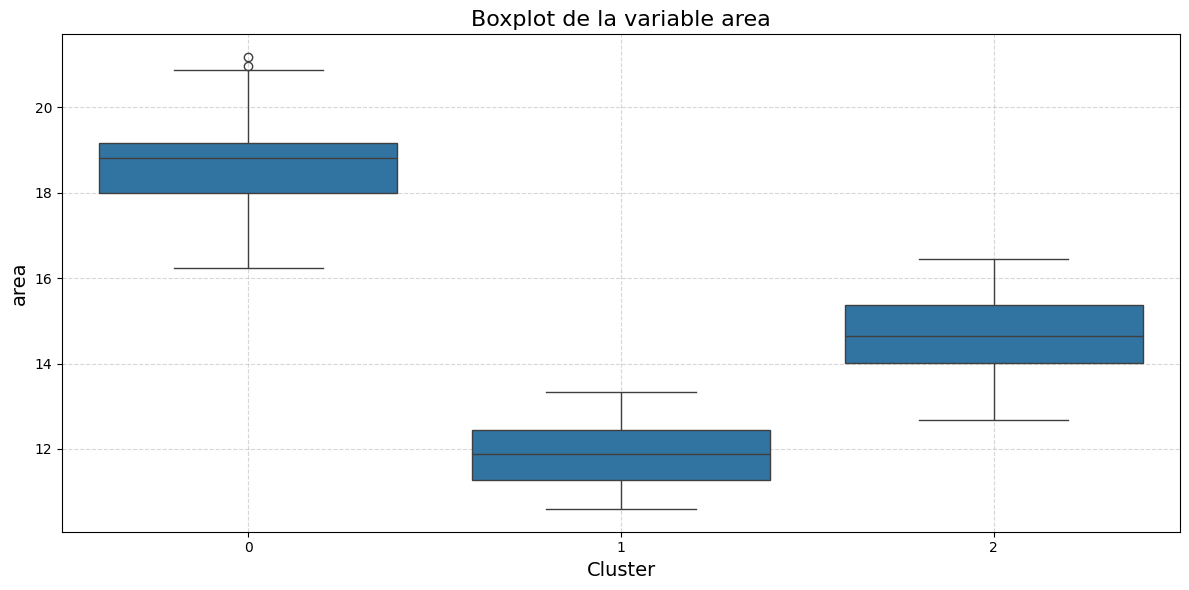

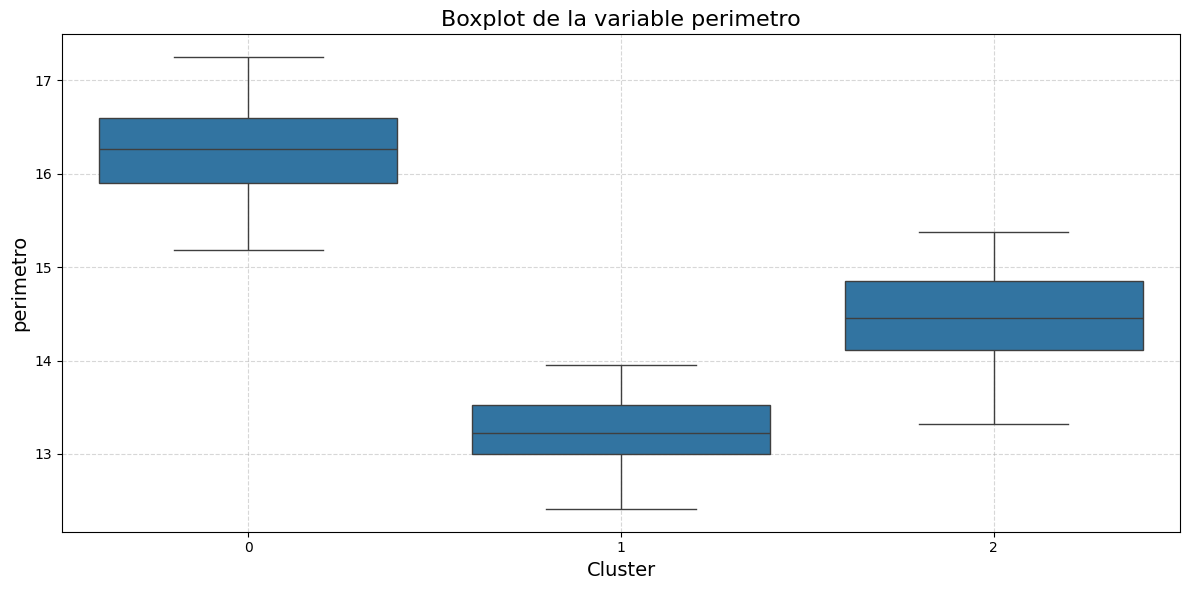

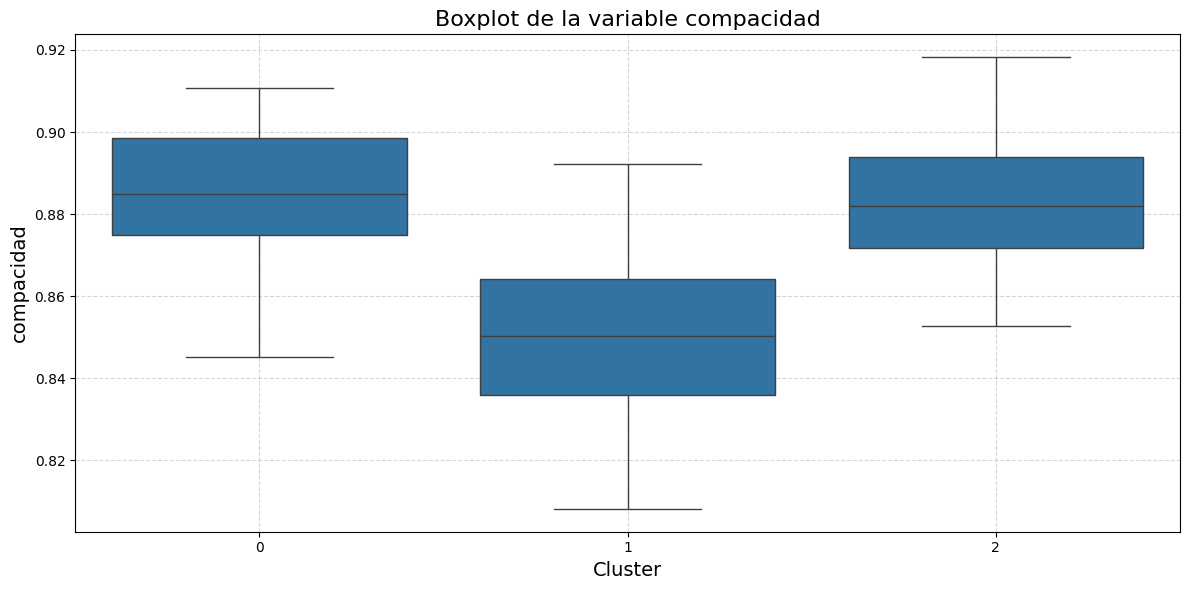

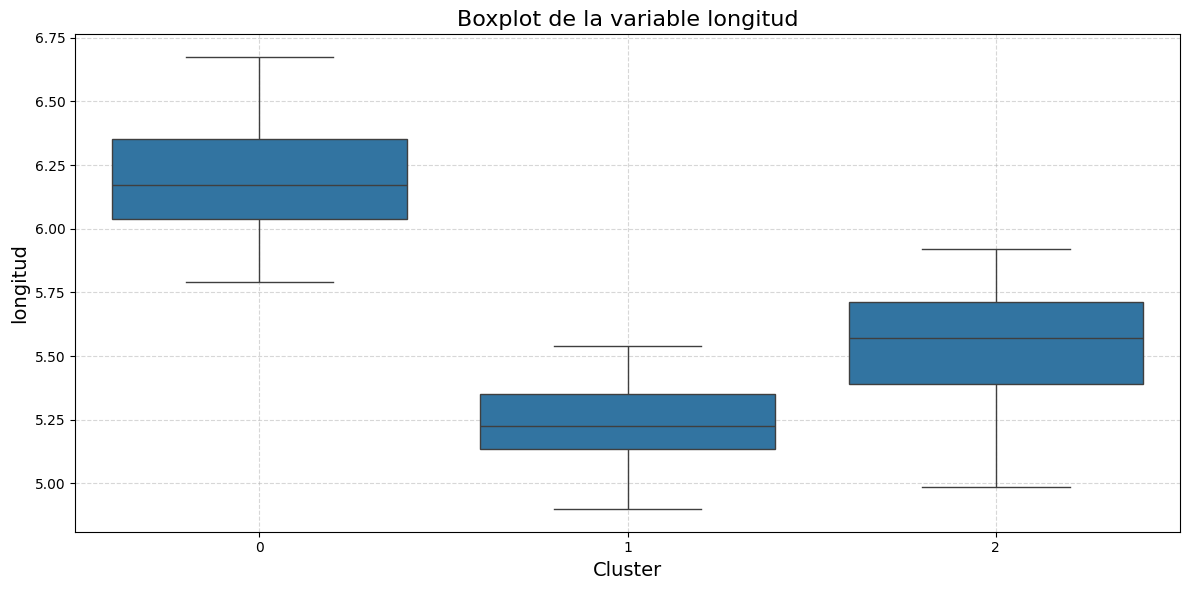

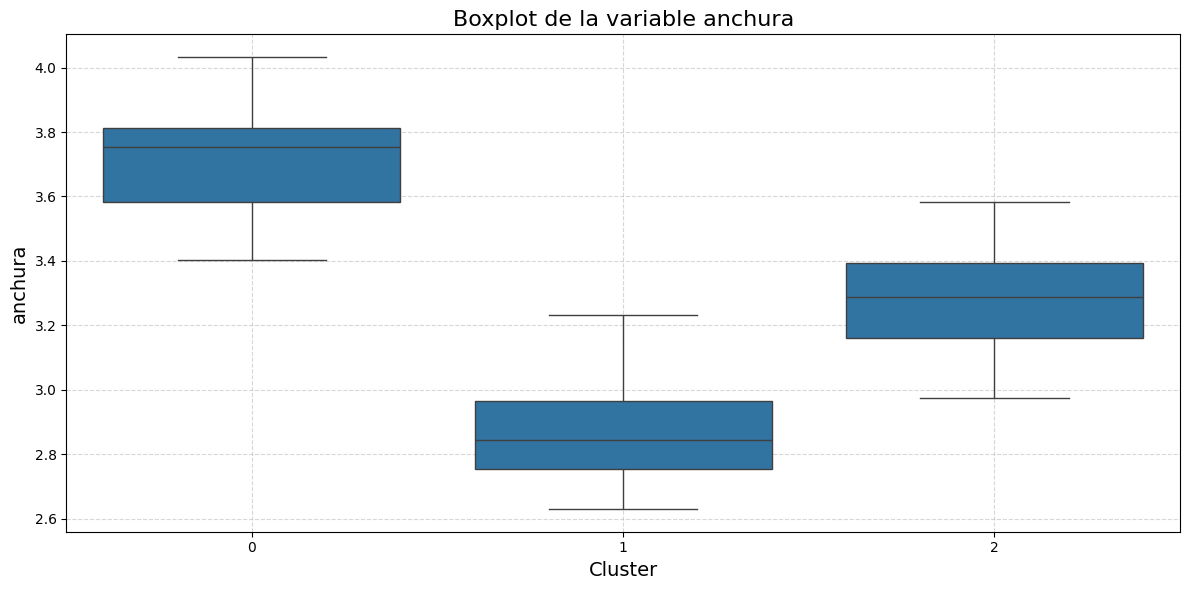

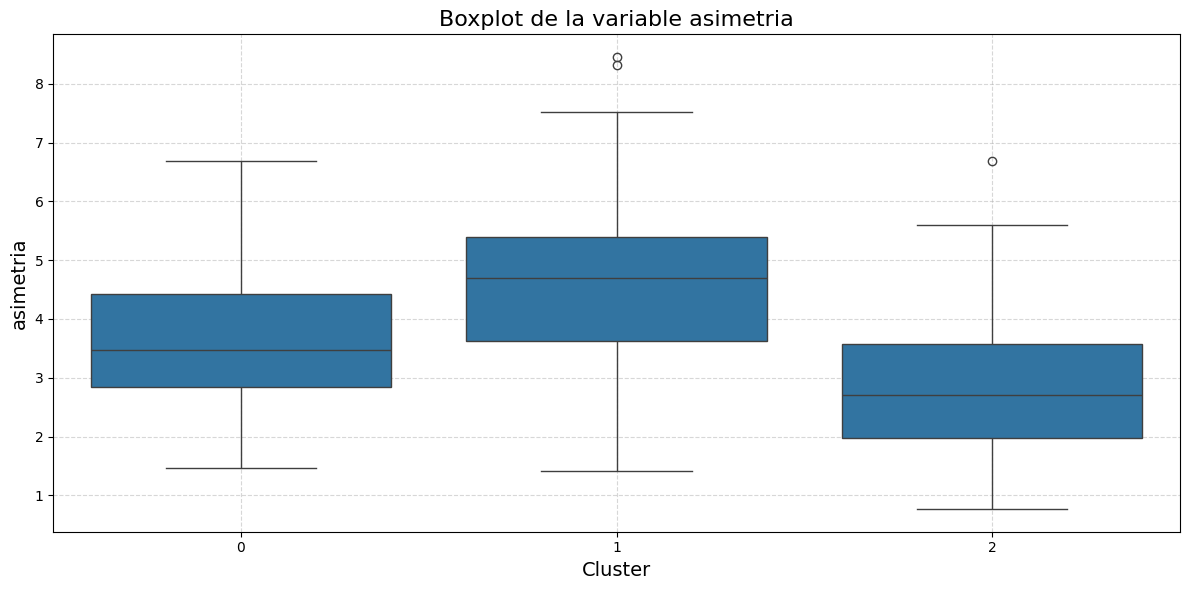

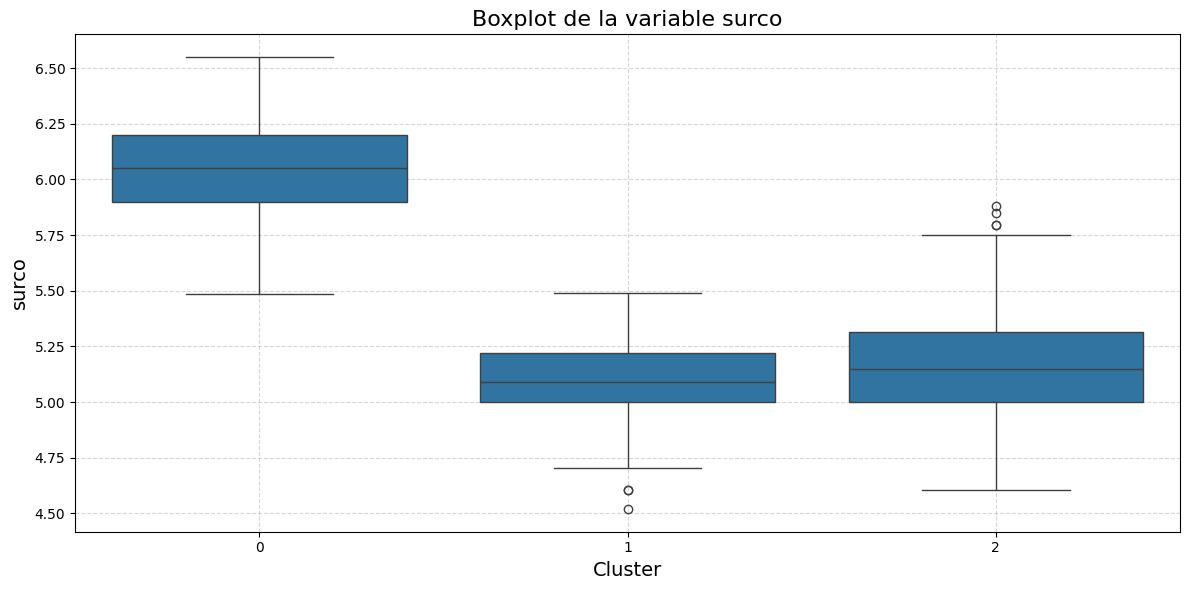

Estadísticas por cluster:
              area            perimetro           compacidad            \
              mean       std       mean       std       mean       std   
cluster                                                                  
0        18.649048  1.152377  16.266349  0.498107   0.884921  0.014814   
1        11.896104  0.713157  13.257662  0.351773   0.849775  0.020403   
2        14.672714  0.971726  14.454714  0.494332   0.881814  0.015402   

         longitud             anchura           asimetria               surco  \
             mean       std      mean       std      mean       std      mean   
cluster                                                                         
0        6.201111  0.221505  3.714603  0.155495  3.581397  1.229148  6.060810   
1        5.230597  0.142286  2.858026  0.138387  4.599545  1.430240  5.086234   
2        5.550943  0.214621  3.288843  0.139541  2.817846  1.237585  5.174629   

                   
              std  
cl

In [125]:
labels = modelo_kmeans.labels_

def analyze_clusters(X_orig, clusters, feature_names):
    # Añadimos las etiquetas de cluster a los datos originales
    df_analysis = X_orig.copy()
    df_analysis['cluster'] = clusters
    
    # Boxplots para cada característica por cluster
    for feature in feature_names:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='cluster', y=feature, data=df_analysis)
        plt.title(f'Boxplot de la variable {feature}', fontsize=16)
        plt.xlabel('Cluster', fontsize=14)
        plt.ylabel(feature, fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    
    # Estadísticas descriptivas por cluster
    cluster_stats = df_analysis.groupby('cluster').agg(['mean', 'std'])
    print("Estadísticas por cluster:")
    print(cluster_stats)
    
    return cluster_stats

best_cluster_stats = analyze_clusters(X, labels, X.columns)
